In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.integrate import solve_ivp
from scipy.optimize import newton

## Question 1

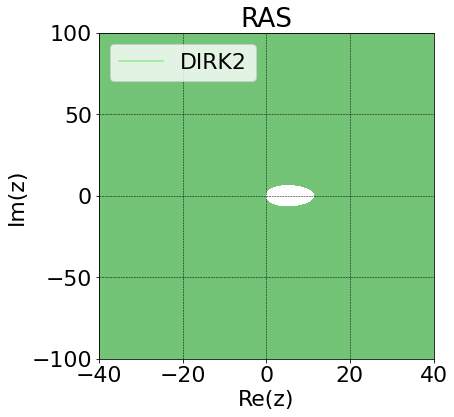

In [2]:
nx = 100
ny = 160
x = np.linspace(-40,40,nx)
y = np.linspace(-100,100,ny)
xg,yg = np.meshgrid(x,y)
gamma = 1 - 1/math.sqrt(2)

z = xg + 1j*yg

f = (1 + z - 2*z*gamma)/(1 - gamma*z)**2
absf = (f.real)**2 + (f.imag)**2


plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(6,6))
plt.contourf(xg,yg,absf, np.arange(4), levels=[0,1], cmap='Greens', alpha=1.0)


FE_line = mlines.Line2D([], [], color='lightgreen', label='DIRK2')
plt.legend(handles=[FE_line], loc='upper left')

plt.title("RAS")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

## Question 2

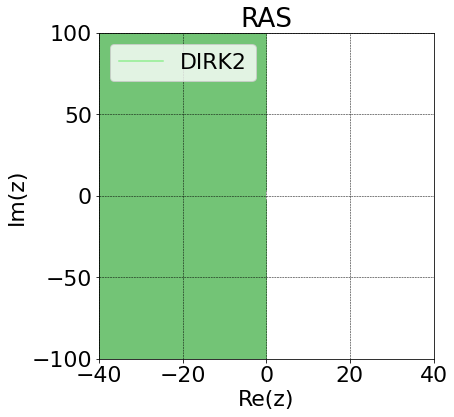

In [3]:
nx = 100
ny = 160
x = np.linspace(-40,40,nx)
y = np.linspace(-100,100,ny)
xg,yg = np.meshgrid(x,y)
gamma = 0.5

z = xg + 1j*yg

f = ( 2 + z*(2 - 4*gamma) + z**2*( 2*gamma**2 - 4*gamma + 1 ) )/(2*(1 - gamma*z)**2)
absf = (f.real)**2 + (f.imag)**2


plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(6,6))
plt.contourf(xg,yg,absf, np.arange(4), levels=[0,1], cmap='Greens', alpha=1.0)


FE_line = mlines.Line2D([], [], color='lightgreen', label='DIRK2')
plt.legend(handles=[FE_line], loc='upper left')

plt.title("RAS")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

## Question 3a

I couldn't find the DIRK2 and DIRK3 methods in the scipy library. Therefore, I coded the solver on my own specialized to the ODE we're solving.

In [4]:
# numerical method: DIRK2

#right hand side of ode
def func(t, y, L):
    
    return -L*(y - math.sin(t + math.pi/4)) + math.cos(t + math.pi/4)

#some more functions

def phi(t):
    
    return math.sin(t + math.pi/4)

def phi_prime(t):
    
    return math.cos(t + math.pi/4)

# true solution
def sol(t,L,x0):
    
    return math.exp(-L*t)*(x0 - math.sin(math.pi/4)) + math.sin(t + math.pi/4)

In [5]:
#DIRK2 and DIRK3 Solvers

def dirk2(x0, t0, t_end, h, gamma, L):
    
    # Initialize time array and solution array
    t = np.arange(t0, t_end + h, h)
    x = np.zeros(len(t))
    soln = np.zeros(len(t))
    x[0] = x0
    
    #compute true solution
    
    for i in range(len(t)):
        
        soln[i] = sol(t[i], L, x0)
    
    for i in range(len(t) - 1):
        
        k1 = (-L*x[i] + L*phi(t[i] + gamma*h) + phi_prime(t[i] + gamma*h))/(1 + L * h * gamma)
        k2 = (-L*x[i] - L*h*(1-gamma)*k1 + L*phi(t[i] + h) + phi_prime(t[i] + h))/(1 + L * h * gamma)

        # Update solution using the numerical method
        x[i+1] = x[i] + h*((1 - gamma)*k1 + gamma*k2)
    
    return t, x, soln


def dirk3(x0, t0, t_end, h, gamma, L):
    
    # Initialize time array and solution array
    t = np.arange(t0, t_end + h, h)
    x = np.zeros(len(t))
    soln = np.zeros(len(t))
    x[0] = x0
    
    #compute true solution
    
    for i in range(len(t)):
        
        soln[i] = sol(t[i], L, x0)
    
    for i in range(len(t) - 1):
        
        k1 = (-L*x[i] + L*phi(t[i] + gamma*h) + phi_prime(t[i] + gamma*h))/(1 + L * h * gamma)
        k2 = (-L*x[i] - L*h*(1-2*gamma)*k1 + L*phi((1-gamma)*t[i] + h) + phi_prime(t[i] + (1-gamma)*h))/(1 + L*h*gamma)

        # Update solution using the numerical method
        x[i+1] = x[i] + 0.5*h*(k1 + k2)
    
    return t, x, soln

In [12]:
# parameters
L = 10**4
t0 = 0
t_end = 10

# initial condition
x0 = math.sin(math.pi/4)

# parameters for step size generation
n = 25
d = 5/24

# step size generation
step_sizes = np.empty(n)

for i in range(0,n):
    
    p = 1 + i*d
    step_sizes[i] = 10**-p

In [13]:
#numerical method: DIRK2

gamma = 1 - 1/math.sqrt(2)
max_error_dirk2 = np.empty(n)

for i in range(0,n):
    
    t, num_sol_dirk2, true_sol = dirk2(x0, t0, t_end, step_sizes[i], gamma, L)
    max_error_dirk2[i] = np.amax(abs(num_sol_dirk2 - true_sol))

In [14]:
#numerical method: DIRK3

gamma = 1/2 + math.sqrt(3)/6
max_error_dirk3 = np.empty(n)

for i in range(0,n):
    
    t, num_sol_dirk3, true_sol = dirk2(x0, t0, t_end, step_sizes[i], gamma, L)
    max_error_dirk3[i] = np.amax(abs(num_sol_dirk3 - true_sol))

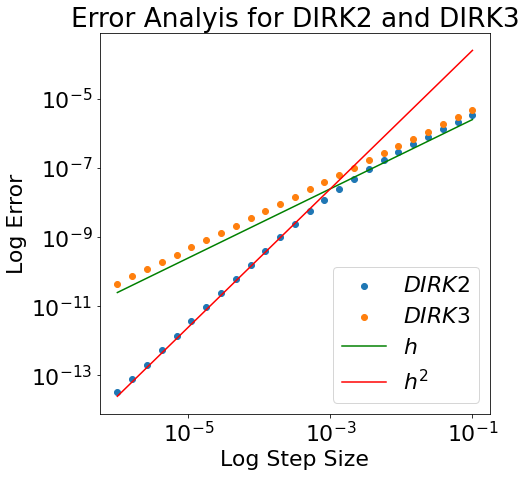

In [15]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7,7))

C1 = 25e-6
C2 = 25e-3

ax.scatter( step_sizes, max_error_dirk2, label= r'$DIRK2$' ) 
ax.scatter( step_sizes, max_error_dirk3, label= r'$DIRK3$'  ) 
ax.plot(step_sizes, C1*step_sizes, label= r'$h$', color='green')
ax.plot(step_sizes, C2*step_sizes**2, label= r'$h^2$', color='red')

plt.title("Error Analyis for DIRK2 and DIRK3")
plt.legend(loc = 'lower right')
plt.xlabel("Log Step Size")
plt.ylabel("Log Error")
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
plt.show()

Since the straight line with slope $1$ seem to fit the error plot for the DIRK3 numerical method, this implies that halving the step-size halves the error. This seem to imply that the order of DIRK3 is one.

Since the straight line with slope $2$ seem to fit the error plot for the DIRK2 numerical method, this implies that halving the step-size decreases the error by a factor of 4. This seem to imply that the order of DIRK2 is two.

We oberve the phenomenon of order reduction.

## Question 3b

In [16]:
# new initial condition
x0 = math.sin(math.pi/4) + 10

In [17]:
#numerical method: DIRK2

gamma = 1 - 1/math.sqrt(2)
max_error_dirk2 = np.empty(n)

for i in range(0,n):
    
    t, num_sol_dirk2, true_sol = dirk2(x0, t0, t_end, step_sizes[i], gamma, L)
    max_error_dirk2[i] = np.amax(abs(num_sol_dirk2 - true_sol))

In [18]:
#numerical method: DIRK3

gamma = 1/2 + math.sqrt(3)/6
max_error_dirk3 = np.empty(n)

for i in range(0,n):
    
    t, num_sol_dirk3, true_sol = dirk3(x0, t0, t_end, step_sizes[i], gamma, L)
    max_error_dirk3[i] = np.amax(abs(num_sol_dirk3 - true_sol))

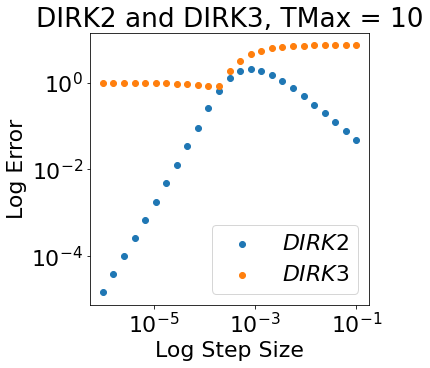

In [19]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter( step_sizes, max_error_dirk2, label= r'$DIRK2$' ) 
ax.scatter( step_sizes, max_error_dirk3, label= r'$DIRK3$' ) 

plt.title("DIRK2 and DIRK3, TMax = 10")
plt.legend(loc = 'lower right')
plt.xlabel("Log Step Size")
plt.ylabel("Log Error")
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
plt.show()

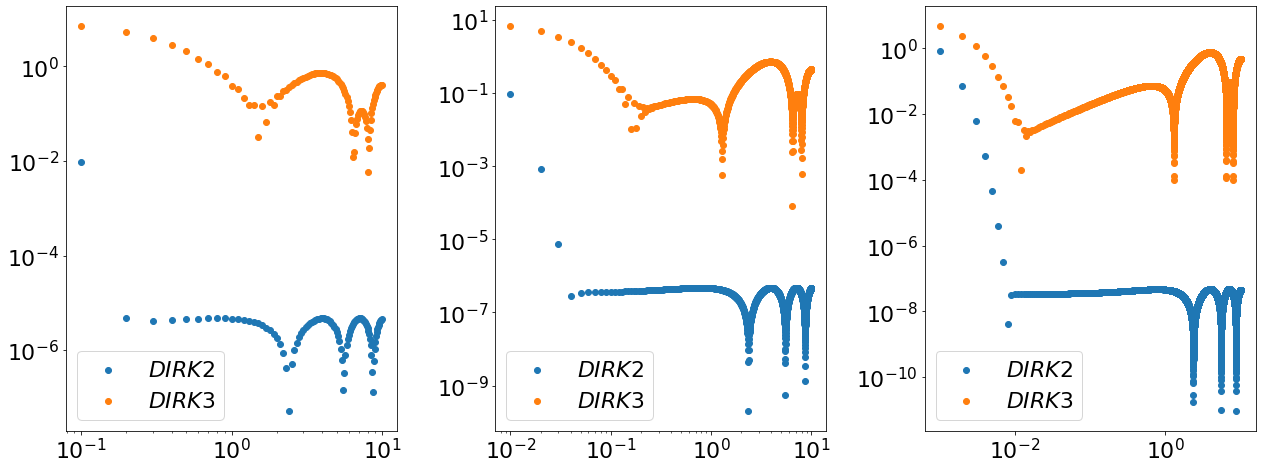

In [11]:
step_sizes = [10**-1, 10**-2, 10**-3]
errors_dirk2 = []
errors_dirk3 = []
time = []

for h in step_sizes:
    
    t, num_sol_dirk2, true_sol = dirk2(x0, t0, t_end, h, gamma, L)
    errors_dirk2.append(abs(num_sol_dirk2 - true_sol))
    
    t, num_sol_dirk3, true_sol = dirk3(x0, t0, t_end, h, gamma, L)
    errors_dirk3.append(abs(num_sol_dirk3 - true_sol))
    
    time.append(t)
    
    
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,7))

ax1.scatter( time[0], errors_dirk2[0], label= r'$DIRK2$' ) 
ax1.scatter( time[0], errors_dirk3[0], label= r'$DIRK3$' ) 
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(loc = 'lower left')

ax2.scatter( time[1], errors_dirk2[1], label= r'$DIRK2$' ) 
ax2.scatter( time[1], errors_dirk3[1], label= r'$DIRK3$' ) 
ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.legend(loc = 'lower left')

ax3.scatter( time[2], errors_dirk2[2], label= r'$DIRK2$' ) 
ax3.scatter( time[2], errors_dirk3[2], label= r'$DIRK3$' ) 
ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.legend(loc = 'lower left')

plt.tight_layout()
plt.show()

## Quetion 3c

We observed order reduction in 3a. For 3b, I am not sure what's going on. The errors seem to oscillate.